# Computer-based exploration of Galton-Watson Processes

Let's assume we have a Galton-Watson Process with a known offspring distribution.

For example, consider a Negative Binomial Distribution with parameters $p$ and $r$.

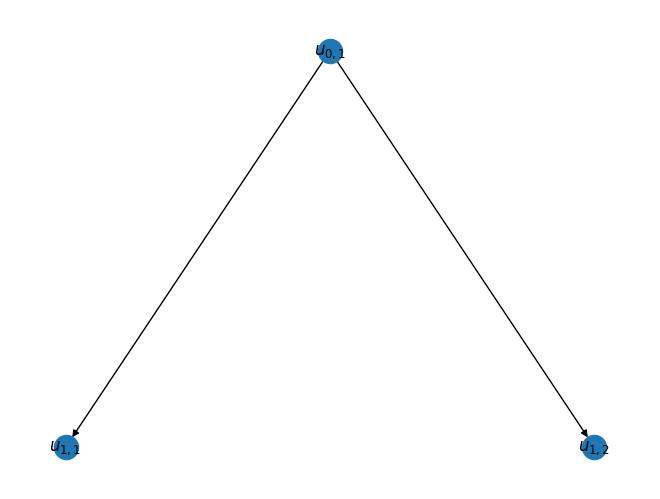

Population sizes by generation: [1 2 0 0 0 0 0 0 0 0 0]


In [1]:
from AMSI_2026_PGF_tools import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# --- Negative binomial offspring distribution ---
# NumPy parameterization: np.random.negative_binomial(n, p)
# returns the number of failures before n successes, with success prob p.
# Mean offspring = n*(1-p)/p


rng = np.random.default_rng()


#Neg Binomial Parameters:

n = 1.5          # "number of successes" (dispersion-ish parameter)
p = 0.5        # success probability

#rng = np.random.default_rng(12345)

def NegBinOffspringDist():
    return rng.negative_binomial(n, p)


# --- Run one simulation ---
G, Xlist = GaltonWatsonTreeSimulation(NegBinOffspringDist, num_generations=10)

# --- Plot the resulting tree ---
pos = hierarchy_pos(G)
nx.draw(G, pos=pos, arrows=True)

labels = { (g, j): rf"$u_{{{g},{j}}}$" for (g, j) in G.nodes }
nx.draw_networkx_labels(G, pos, labels=labels)
plt.show()

print("Population sizes by generation:", Xlist)
# print("Total individuals in tree:", G.number_of_nodes())
# print("Total parent->child edges:", G.number_of_edges())



Rerun the code above a few times and it should give various different results.




Next we're going to look at extinction probability  The code below runs many simulations, and estimates the extinction probability based on that.  By default it decides extinction has happened if $X_g=0$ by $g=10$.  Then it plots the PGF and the line $y=x$. Run this with various parameters.  Try making the mean larger than, smaller than, and close to $1$

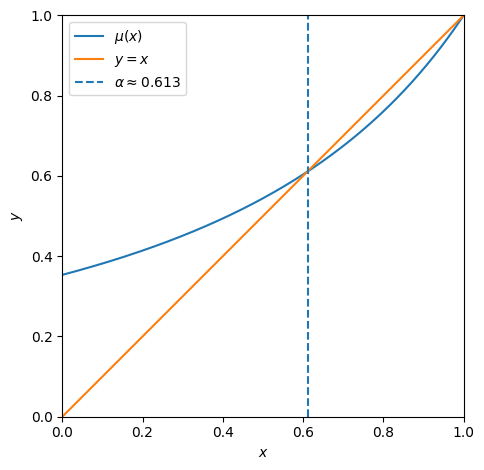

In [11]:
def estimate_extinction_probability(r, p, OffspringDist, nsim=1000, max_generations=10):
    extinct_count = 0
    for _ in range(nsim):
        Xlist = GaltonWatsonSimulation(OffspringDist, num_generations=max_generations)
        if Xlist[-1]==0:
            extinct_count += 1
    return extinct_count / nsim

def nb_pgf(x, r, p):  #the PGF for the negative binomial distribution
    return (p / (1 - (1 - p)*x))**r


r = 1.5
p = 0.5


def NegBinOffspringDist():
    return rng.negative_binomial(n, p)


alpha = estimate_extinction_probability(r, p, NegBinOffspringDist)
# print(alpha)

x = np.linspace(0, 1, 1000)
mu_x = nb_pgf(x, r, p)

plt.plot(x, mu_x, label=r"$\mu(x)$")
plt.plot(x, x, label=r"$y=x$")
plt.axvline(alpha, linestyle="--",
            label=rf"$\alpha \approx {alpha:.3f}$")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.tight_layout()
plt.show()


Next we'll look at the probability of extinction by generation $g$

The first plot shows how the extinction probability as predicted and as simulated converge as $g$ increases.

The second shows how the prediction looks as a "cobweb diagram" when plotted with the PGF.

Try seeing how fast convergence happens when $\mu'(1)=1$.


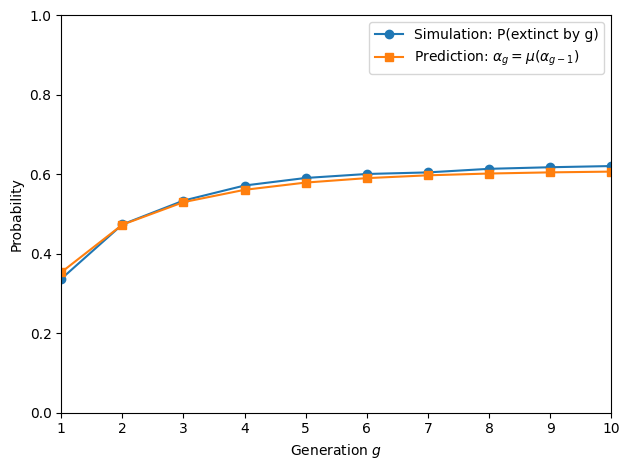

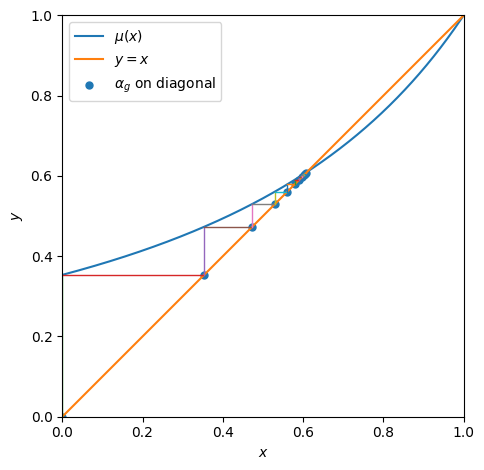

 g   sim P(X_g=0)     alpha_g
 1    0.337000        0.353553
 2    0.474000        0.473346
 3    0.534000        0.530138
 4    0.572000        0.561158
 5    0.591000        0.579402
 6    0.601000        0.590600
 7    0.605000        0.597652
 8    0.614000        0.602166
 9    0.618000        0.605085
10    0.621000        0.606986


In [10]:
import numpy as np
import matplotlib.pyplot as plt

from AMSI_2026_PGF_tools.Galton_Watson import GaltonWatsonSimulation

# Parameters
r = 1.5
p = 0.5
gmax = 10
nsim = 1000

rng = np.random.default_rng()

def OffspringDist():
    return int(rng.negative_binomial(r, p))

def mu(x):
    return (p / (1 - (1 - p) * x)) ** r

# --- Simulation: estimate P(X_g=0) for g=1..gmax ---
extinct_by_g = np.zeros(gmax + 1, dtype=int)  # count first extinction at generation g

for _ in range(nsim):
    X = GaltonWatsonSimulation(OffspringDist, num_generations=gmax)  # should return length gmax+1
    # Find first generation where extinct
    for g in range(1, gmax + 1):
        if X[g] == 0:
            extinct_by_g[g] += 1
            break

sim_P_extinct_by_g = np.cumsum(extinct_by_g) / nsim  # P(X_g=0)

# --- Prediction: alpha recursion ---
alpha = np.zeros(gmax + 1, dtype=float)
alpha[0] = 0.0
for g in range(1, gmax + 1):
    alpha[g] = mu(alpha[g - 1])

# --- Plot ---
gvals = np.arange(1, gmax + 1)

plt.figure()
plt.plot(gvals, sim_P_extinct_by_g[1:], marker="o", label="Simulation: P(extinct by g)")
plt.plot(gvals, alpha[1:], marker="s", label=r"Prediction: $\alpha_g=\mu(\alpha_{g-1})$")
plt.xlim(1, gmax)
plt.ylim(0, 1)
plt.xlabel("Generation $g$")
plt.ylabel("Probability")
plt.legend()
plt.tight_layout()
plt.show()


# --- Cobweb diagram (uses alpha[0..gmax] and mu) ---

x = np.linspace(0, 1, 1000)
mu_x = mu(x)

plt.figure()
plt.plot(x, mu_x, label=r"$\mu(x)$")
plt.plot(x, x, label=r"$y=x$")
plt.gca().set_aspect("equal", adjustable="box")
# Cobweb starting at (alpha0, 0) = (0,0)
a = alpha[0]
for g in range(1, gmax + 1):
    a_next = alpha[g]          # = mu(a)

    # vertical step: (a, a) -> (a, mu(a)) (or from (a,0) at start it's the same since a=0)
    plt.plot([a, a], [a, a_next], linewidth=1)

    # horizontal step: (a, mu(a)) -> (mu(a), mu(a)) = (a_next, a_next)
    plt.plot([a, a_next], [a_next, a_next], linewidth=1)

    a = a_next

# Mark the alpha_g points on the diagonal
plt.scatter(alpha[:gmax+1], alpha[:gmax+1], s=25, label=r"$\alpha_g$ on diagonal")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.tight_layout()
plt.show()

print(" g   sim P(X_g=0)     alpha_g")
for g in gvals:
    print(f"{g:2d}   {sim_P_extinct_by_g[g]: .6f}       {alpha[g]: .6f}")


Now we'll look at the size distribution at generation $g=5$.  This calculates $\Phi_g(e^{i\theta})$ and then uses Cauchy integrals (actually Fast Fourier Transforms) to find the coefficients.



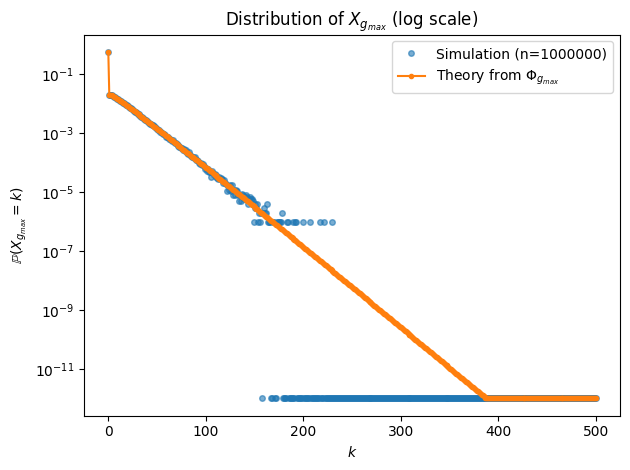

In [12]:
from AMSI_2026_PGF_tools.Galton_Watson import GaltonWatsonSimulation, Phi_coefficients_real
                               
import numpy as np
import matplotlib.pyplot as plt


# Parameters
r = 1.5
p = 0.5
gmax = 5
nsim = 1000000
g = 5

numCoefficients = 500

rng = np.random.default_rng()

def OffspringDist():
    return int(rng.negative_binomial(r, p))

def mu(x):
    return (p / (1 - (1 - p) * x)) ** r


# --- theory: P(X_g = k) from coefficients of Phi_g ---
p_theory = np.asarray(Phi_coefficients_real(g, numCoefficients, mu), dtype=float)  # length numCoefficients

# --- simulation: sample X_g many times ---
Xg = np.zeros(nsim, dtype=int)
for i in range(nsim):
    X = GaltonWatsonSimulation(OffspringDist, num_generations=g)  # returns X_0,...,X_g
    Xg[i] = int(X[g])

# empirical pmf with a tail bin at k = numCoefficients (meaning ">= numCoefficients")
counts = np.bincount(np.clip(Xg, 0, numCoefficients), minlength=numCoefficients + 1)
p_emp = counts / nsim

# theory tail bin
p_tail = max(0.0, 1.0 - p_theory.sum())
p_theory_with_tail = np.concatenate([p_theory, [p_tail]])

k = np.arange(numCoefficients + 1)

eps = 1e-12  # floor for log scale

plt.figure()

# Simulation: points
plt.plot(
    k,
    np.maximum(p_emp, eps),
    linestyle="none",
    marker="o",
    markersize=4,
    alpha=0.6,
    label=f"Simulation (n={nsim})"
)

# Theory: thin line + markers
plt.plot(
    k,
    np.maximum(p_theory_with_tail, eps),
    linestyle="-",
    marker=".",
    linewidth=1.5,
    label=r"Theory from $\Phi_{g_{max}}$"
)

plt.yscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$\mathbb{P}(X_{g_{max}}=k)$")
plt.title(r"Distribution of $X_{g_{max}}$ (log scale)")
plt.legend()
plt.tight_layout()
plt.show()
